In [1]:
import serial
from time import sleep
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [3]:
def a2s(arr):
    """ Array of integer byte values --> binary string
    """
    return ''.join(chr(b) for b in arr)

In [3]:
try:
    ser = serial.Serial('/dev/ttyACM0', 9600) # Establish the connection on a specific port
except:
    ser = serial.Serial('/dev/ttyACM1', 9600) # Establish the connection on a specific port

In [2]:
ser = serial.Serial('/dev/cu.usbmodem1421', 9600)

In [4]:
def commarduino(ser,azim,elev):
    # this azim must be already elevation offset-corrected
    azbin=bin(azim*10) # arduino serial receives a 16 bit int, so we have 1 decimal precision if multiplied by 10
    azpadn=16-len(azbin[2:])
    azbin='0b'+azpadn*'0'+azbin[2:]
    altbin=bin(elev*10) # arduino serial receives a 16 bit int, so we have 1 decimal precision if multiplied by 10
    altpadn=16-len(altbin[2:])
    altbin='0b'+altpadn*'0'+altbin[2:]
    # split each coordinate's 16 bit int into two 8 bit ints
    # is reconstituted in the arduino
    ser.write(a2s([int(azbin[2:-8],2),int(azbin[-8:],2),int(altbin[2:-8],2),int(altbin[-8:],2)]))
#    sleep(15)

In [5]:
ser

Serial<id=0x110b4f7d0, open=True>(port='/dev/cu.usbmodem1421', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)

In [6]:
def readarduino(ser):
    did=True
    while ser.inWaiting():
        if did and ser.inWaiting() < 490:
            for i in range(6):
            #print ser.readline()[0:50]
                print ser.readline()[0:60]
            did = False
        ser.readline()    

In [7]:
def readard(ser):
    if ser.inWaiting() > 500:
        readarduino(ser)
    else:
        sleep(5)
        readarduino(ser)

In [9]:
readard(ser)

Az should be lower than 3600 and Alt should be lower than 90
Stopping the telescope now. Waiting for new coordinates.

0	0	0	0	4000	1000	roll: 0    pitch: 0    angle full: 146.9  
Angles from computer are inconsistent.

Az should be lower than 3600 and Alt should be lower than 90
Stopping the telescope now. Waiting for new coordinates.



In [8]:
def commwrap(ser,azim,elev):
    print "************"
    print "Before write"
    print "************"
    readard(ser)
    for i in range(2):
        commarduino(ser,azim,elev)
        sleep(5)
    print "***********"
    print "After write"
    print "***********"
    readard(ser)

In [26]:
commwrap(ser,361,9)

************
Before write
************
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
9	36	1	244	2340	500	roll: 0    pitch: -2    angle full: 142.
***********
After write
***********
14	26	0	90	3610	90	roll: 0    pitch: -2    angle full: 142.6
Angles from computer are inconsistent.

Az should be lower than 3600 and Alt should be lower than 90
Stopping the telescope now. Waiting for new coordinates.

14	26	0	90	3610	90	roll: 0    pitch: -2    angle full: 142.7
Angles from computer are inconsistent.



In [10]:
# azimuth correction due to pitch offset
def az_corr(eloff,el):
    el=el*np.pi/180
    eloff=eloff*np.pi/180
    omega=np.arcsin(np.sin(el)/np.cos(eloff))
    return -np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff))*180/np.pi

In [11]:
eloff=4 ## offset, should be measured via pitch

In [12]:
# this block sets the availability of az for each el
azlimlo=360 # this should me measured (max az range for the antenna mount)
azlimup=180 # this should me measured (min az range for the antenna mount)
el=np.linspace(0,90-eloff,90-eloff+1)*np.pi/180
omega=np.arcsin(np.sin(el)/np.cos(eloff*np.pi/180))
azcor=-np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff*np.pi/180))*180/np.pi
lowerang=azlimlo-azcor-360
upperang=azlimup-azcor

In [13]:
obj = SkyCoord(266.41, -29.01, unit="deg")
ecci = EarthLocation(lat=4.71*u.deg, lon=-72.07*u.deg, height=2600*u.m)
utcoffset = 5*u.hour  # Bogota time

for i in range(15):
    print "****************************"
    print "New coordinates from script:"
    print "****************************"
    time = Time.now()
    objaltaz = obj.transform_to(AltAz(obstime=time,location=ecci))  
    azimuth=int(np.around(objaltaz.az.degree,0))
    elevation=int(np.around(objaltaz.alt.degree,0))
    filtel=(np.around((el*180/np.pi),0).astype(int)==elevation)
    print time - utcoffset," Azimuth = ",azimuth, "Elevation = ", elevation
    if (elevation > 0):
        if not(lowerang[filtel] < azimuth < upperang[filtel]):
            print "Desired Az must be between %i and %i" %(lowerang[filtel][0],upperang[filtel][0])
            print "Az is currently set to %i" % azimuth
            print "Stopping the telescope now. Waiting for new coordinates from the astropy block."
            azimuth = 361
            elevation = 91
            commwrap(ser,azimuth,elevation)
            ## communicate this to the arduino
        else:
            print "Setting the telescope to Az = %i and El = %i" %(azimuth, elevation)
            print "Corrected azimuth = % i" % (np.around(azimuth-az_corr(eloff,elevation),0))
            commwrap(ser,int(np.around(azimuth-az_corr(eloff,elevation),0)),elevation)
            ## communicate corrected azimuth to the arduino
        print  " "
    else:
        print "Desired El must be greater than zero"
        print "El is currently set to %i" % elevation
        print "Stopping the telescope now. Waiting for new coordinates from the astropy block."
        azimuth = 361
        elevation = 91
        commarduino(ser,azimuth,elevation)
        ## communicate this to the arduino
    sleep(30) # this should be at least an order of magnitude higher than the arduino loop delay

****************************
New coordinates from script:
****************************
2016-11-18 15:22:45.683972  Azimuth =  214 Elevation =  48
Setting the telescope to Az = 214 and El = 48
Corrected azimuth =  300
************
Before write
************
0	0	0	0	4000	1000	roll: 0    pitch: 0    angle full: 147.0  
Angles from computer are inconsistent.

Az should be lower than 3600 and Alt should be lower than 90
Stopping the telescope now. Waiting for new coordinates.

0	0	0	0	4000	1000	roll: 0    pitch: 0    angle full: 147.1  
Angles from computer are inconsistent.

***********
After write
***********
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 147
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 147
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 146
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 147
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 147
11	184	1	224	3000	480	roll: 0    pitch: 0    angle full: 147
 
*******************

In [31]:
ser.close()

In [28]:
# Observation plan
for i in range(24):
    ecci = EarthLocation(lat=4.71*u.deg, lon=-72.07*u.deg, height=2600*u.m)
    for j in ['00','15','30','45']:
        time = Time('%s %i:%s:00' % (str(time.now())[:10],i,j)) 
        objaltaz = obj.transform_to(AltAz(obstime=time,location=ecci))  
        print time - utcoffset, " Object altitude = {0.alt:.1f}".format(objaltaz)," Object azimuth = {0.az:.1f}".format(objaltaz) 

2016-11-17 19:00:00.000  Object altitude = 7.5 deg  Object azimuth = 239.9 deg
2016-11-17 19:15:00.000  Object altitude = 4.3 deg  Object azimuth = 240.4 deg
2016-11-17 19:30:00.000  Object altitude = 1.0 deg  Object azimuth = 240.8 deg
2016-11-17 19:45:00.000  Object altitude = -2.3 deg  Object azimuth = 241.1 deg
2016-11-17 20:00:00.000  Object altitude = -5.6 deg  Object azimuth = 241.3 deg
2016-11-17 20:15:00.000  Object altitude = -8.9 deg  Object azimuth = 241.3 deg
2016-11-17 20:30:00.000  Object altitude = -12.1 deg  Object azimuth = 241.3 deg
2016-11-17 20:45:00.000  Object altitude = -15.4 deg  Object azimuth = 241.2 deg
2016-11-17 21:00:00.000  Object altitude = -18.7 deg  Object azimuth = 240.9 deg
2016-11-17 21:15:00.000  Object altitude = -22.0 deg  Object azimuth = 240.6 deg
2016-11-17 21:30:00.000  Object altitude = -25.2 deg  Object azimuth = 240.1 deg
2016-11-17 21:45:00.000  Object altitude = -28.5 deg  Object azimuth = 239.4 deg
2016-11-17 22:00:00.000  Object altit

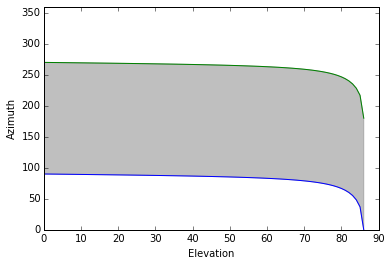

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
azlimlo=360
azlimup=180
el=np.linspace(0,90-eloff,90-eloff+1)*np.pi/180
omega=np.arcsin(np.sin(el)/np.cos(eloff*np.pi/180))
azcor=-np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff*np.pi/180))*180/np.pi
lowerang=azlimlo-azcor-360
upperang=azlimup-azcor
plt.plot(el*180/np.pi,lowerang)
plt.plot(el*180/np.pi,upperang)
plt.fill_between(el*180/np.pi,lowerang, upperang, color='grey', alpha='0.5')
plt.ylim(0,360)
plt.xlabel("Elevation")
plt.ylabel("Azimuth")
filtel=el*180/np.pi==elevation